In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa # pyarrow 테이블 변환을 위해 임포트
import os

# (pyarrow 설치 필요: !pip install pyarrow)

SOURCE_FILE = 'df_master_preprocessed.parquet'
TARGET_FILE = 'df_filtered_2013_2017.parquet' # (새로 생성될 파일)
CHUNK_SIZE = 500000 # 한 번에 50만 행씩 읽기

# (Parquet 파일에 'date' 컬럼이 있는지 확인해야 함)
try:
    schema = pq.read_schema(SOURCE_FILE)
    if 'date' not in schema.names:
        print(f"오류: '{SOURCE_FILE}'에 'date' 컬럼이 없습니다.")
        print("EDA+Preprocessing 노트북에서 'date' 컬럼을 포함하여 다시 저장해야 합니다.")
    else:
        print(f"'{SOURCE_FILE}'에서 2013, 2017년 데이터 필터링 시작...")
        
        # 1. Parquet 파일 열기
        parquet_file = pq.ParquetFile(SOURCE_FILE)
        
        # 2. Parquet 파일 쓰기 준비 (TARGET_FILE)
        writer = None
        
        total_rows_processed = 0
        total_rows_saved = 0
        
        # 3. Chunk 단위로 반복 처리
        for i, batch in enumerate(parquet_file.iter_batches(batch_size=CHUNK_SIZE, columns=['date', 'style', 'country_brewery', 'abv', 'smell', 'taste', 'feel', 'score', 'username', 'beer_id'])):
            print(f"Processing chunk {i+1}...")
            
            # 3-1. Chunk를 Pandas DataFrame으로 변환
            chunk_df = batch.to_pandas()
            
            # 3-2. 날짜 변환 및 필터링
            chunk_df['datetime'] = pd.to_datetime(chunk_df['date'], errors='coerce')
            chunk_df['year'] = chunk_df['datetime'].dt.year
            
            filtered_chunk = chunk_df[chunk_df['year'].isin([2013, 2017])].copy()
            
            # (필터링된 데이터에서 불필요한 날짜 컬럼 제거)
            filtered_chunk = filtered_chunk.drop(columns=['datetime', 'year'])
            
            # 3-3. 필터링된 Chunk를 새 Parquet 파일에 추가
            if not filtered_chunk.empty:
                total_rows_saved += len(filtered_chunk)
                
                # PyArrow 테이블로 변환
                table_to_write = pa.Table.from_pandas(filtered_chunk, preserve_index=False)
                
                if writer is None:
                    # 첫 번째 Chunk는 스키마와 함께 쓰기 시작
                    writer = pq.ParquetWriter(TARGET_FILE, table_to_write.schema)
                
                writer.write_table(table_to_write)
                
            total_rows_processed += len(chunk_df)

        if writer:
            writer.close()
            print("\n--- 필터링 완료 ---")
            print(f"총 처리된 행: {total_rows_processed}")
            print(f"저장된 행 (2013/2017): {total_rows_saved}")
            print(f"필터링된 데이터가 '{TARGET_FILE}'에 저장되었습니다.")
        else:
            print("\n저장된 데이터가 없습니다. 'date' 컬럼이나 파일 경로를 확인하세요.")

except FileNotFoundError:
    print(f"오류: '{SOURCE_FILE}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

'df_master_preprocessed.parquet'에서 2013, 2017년 데이터 필터링 시작...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...

--- 필터링 완료 ---
총 처리된 행: 8417033
저장된 행 (2013/2017): 1863769
필터링된 데이터가 'df_filtered_2013_2017.parquet'에 저장되었습니다.


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import implicit
from scipy.sparse import csr_matrix

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# --- 0. 하이퍼파라미터 ---
FILTERED_FILE = 'df_filtered_2013_2017.parquet' # (1단계 필터링 코드에서 생성된 파일)
SAMPLE_FRAC = 1 
K_BEERS = 6
K_USERS = 8

In [2]:
# --- 1. (Pandas) 필터링된 데이터 로드 및 샘플링 ---
print(f"--- 1. 필터링된 데이터 로드 및 샘플링 (FRAC={SAMPLE_FRAC}) ---")
try:
    df_filtered = pd.read_parquet(FILTERED_FILE)
    print(f"필터링된 데이터 로드 성공. 크기: {df_filtered.shape}")
    
    print("\n--- Reviews DataFrame Info (Data Types) ---")
    df_filtered.info()
    
    # --- 2. (중요) 샘플링 ---
    # (예: 300만 행 -> 30만 행)
    df_sample = df_filtered.sample(frac=SAMPLE_FRAC, random_state=42)
    print(f"샘플링 완료. 최종 학습 데이터 크기: {df_sample.shape}")

    # 더 이상 원본 df_filtered는 필요 없으므로 메모리에서 즉시 삭제
    del df_filtered 
    print("메모리에서 원본 'df_filtered' (필터링된 전체 데이터)를 삭제했습니다.")
    
except FileNotFoundError:
    print(f"오류: '{FILTERED_FILE}'를 찾을 수 없습니다.")
    print("[1단계: 필터링 전용 코드]를 먼저 실행하여 Parquet 파일을 생성해야 합니다.")
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")

--- 1. 필터링된 데이터 로드 및 샘플링 (FRAC=1) ---
필터링된 데이터 로드 성공. 크기: (1863769, 10)

--- Reviews DataFrame Info (Data Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863769 entries, 0 to 1863768
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   style            object 
 2   country_brewery  object 
 3   abv              float64
 4   smell            float64
 5   taste            float64
 6   feel             float64
 7   score            float64
 8   username         object 
 9   beer_id          int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 142.2+ MB
샘플링 완료. 최종 학습 데이터 크기: (1863769, 10)
메모리에서 원본 'df_filtered' (필터링된 전체 데이터)를 삭제했습니다.


In [3]:
# (REPLACEMENT FOR Cell 4: 8bafcd95)
# --- 3. (NEW) Feature Engineering (7 Style Groups) ---
print("\n--- 'style_group' 및 'geo_group' 피처 생성 중 (7-Group) ---")

def group_style(style):
    if pd.isna(style): return 'Other'
    style = str(style) # Ensure string
    if 'IPA' in style: return 'IPA'
    if 'Stout' in style: return 'Stout'
    if 'Ale' in style: return 'Ale' # Pale Ale, Amber Ale, Brown Ale...
    if 'Lager' in style or 'Pilsner' in style or 'Hefeweizen' in style: return 'Lager/Wheat'
    if 'Saison' in style or 'Belgian' in style or 'Witbier' in style: return 'Belgian/Saison'
    if 'Wild Ale' in style or 'Berliner Weisse' in style: return 'Sour/Wild'
    return 'Other' # Porter, Fruit Beer, etc.

df_sample['style_group'] = df_sample['style'].apply(group_style)
print("\nStyle groups created:")
print(df_sample['style_group'].value_counts())

def group_country(country):
    if pd.isna(country): return 'Other'
    if country == 'US': return 'US'
    if country in ['DE', 'GB', 'BE', 'DK', 'NL', 'NO', 'IT', 'SE', 'CZ']: return 'Europe'
    if country == 'CA': return 'Canada'
    return 'Other' # Asia, South America, etc.

df_sample['geo_group'] = df_sample['country_brewery'].apply(group_country)
print("\nGeo groups created:")
print(df_sample['geo_group'].value_counts())

print("\nFeature Engineering (style_group, geo_group) complete on df_sample.")


--- 'style_group' 및 'geo_group' 피처 생성 중 (7-Group) ---

Style groups created:
style_group
IPA               474948
Ale               458003
Other             350494
Stout             271598
Belgian/Saison    170732
Lager/Wheat       122072
Sour/Wild          15922
Name: count, dtype: int64

Geo groups created:
geo_group
US        1580858
Europe     190672
Other       46494
Canada      45745
Name: count, dtype: int64

Feature Engineering (style_group, geo_group) complete on df_sample.


# SVD 실행 Latent 생성->옛날 버전 (밑의 버전으로 실행해주세요)

In [5]:
# (NEW CELL) - Cell 4와 Cell 6 사이에 삽입하세요.
# --- 3-A. Latent Feature 추출 (SVD) ---

print("\n--- 3-A. Latent Feature 추출 (SVD) ---")

# 1. User-Item Rating Matrix 생성 (df_sample 사용)
# SVD는 NaN을 허용하지 않으므로 .fillna(0)으로 처리합니다.
try:
    rating_matrix = df_sample.pivot_table(index='username', columns='beer_id', values='score').fillna(0)
    # pivot_table 결과가 너무 클 수 있으므로 csr_matrix로 변환
    rating_sparse = csr_matrix(rating_matrix.values)
    
    # 2. SVD 수행
    N_COMPONENTS = 10 # Latent Factor 개수 (하이퍼파라미터)
    svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
    
    # User와 Beer의 잠재 요인 추출
    user_latent_factors = svd.fit_transform(rating_sparse)
    beer_latent_factors = svd.components_.T
    
    # 3. DataFrame으로 변환 (나중에 Merge하기 위함)
    # User Latent Factors (인덱스: username)
    user_latent_df = pd.DataFrame(
        user_latent_factors, 
        index=rating_matrix.index, 
        columns=[f'user_latent_{i}' for i in range(N_COMPONENTS)]
    )
    
    # Beer Latent Factors (인덱스: beer_id)
    beer_latent_df = pd.DataFrame(
        beer_latent_factors, 
        index=rating_matrix.columns, 
        columns=[f'beer_latent_{i}' for i in range(N_COMPONENTS)]
    )
    
    # beer_id가 인덱스에 있으므로, reset_index()로 컬럼으로 변환
    beer_latent_df = beer_latent_df.reset_index().rename(columns={'index': 'beer_id'})

    print(f"SVD 완료. User Latent Factors: {user_latent_df.shape}, Beer Latent Factors: {beer_latent_df.shape}")

except ValueError as e:
    print(f"SVD 수행 중 오류: {e}")
    print("df_sample에 데이터가 충분하지 않거나 메모리 문제일 수 있습니다.")
except Exception as e:
    print(f"알 수 없는 오류 발생: {e}")


--- 3-A. Latent Feature 추출 (SVD) ---
SVD 완료. User Latent Factors: (24540, 10), Beer Latent Factors: (80058, 11)


# A_1. New SVD Used by implicit

In [4]:
# (REPLACEMENT FOR Cell 7: 435e54a4) - Latent Feature 추출 (ALS / Implicit)

import implicit
from scipy.sparse import csr_matrix
import pandas as pd
import time 

print("\n--- 3-A. Latent Feature 추출 (ALS / Implicit) ---")
N_COMPONENTS = 10 

if 'df_sample' not in locals():
    print("!!! 오류: df_sample 데이터가 없습니다. 이전 셀을 확인하세요.")
else:
    try:
        start_time = time.time() # Start timer
        
        # 1. Data Preparation: 'username'과 'beer_id'를 정수 ID로 매핑
        print("Data Preparation (Categorizing IDs)...")
        user_categories = df_sample['username'].astype('category')
        user_id_map = user_categories.cat.categories
        df_sample['user_id'] = user_categories.cat.codes
        
        item_categories = df_sample['beer_id'].astype('category')
        item_id_map = item_categories.cat.categories
        df_sample['item_id'] = item_categories.cat.codes

        # 2. Sparse Matrix 생성 (Pivot Table X)
        print("Sparse Matrix (Items x Users) 생성 중...")
        sparse_matrix = csr_matrix(
            (df_sample['score'], (df_sample['item_id'], df_sample['user_id'])), # (Rows=Items, Cols=Users)
            shape=(len(item_id_map), len(user_id_map))
        )

        # 3. Initialize & Train ALS Model
        als_model = implicit.als.AlternatingLeastSquares(
            factors=N_COMPONENTS, 
            regularization=0.01, 
            iterations=50, 
            random_state=42,
            num_threads=0 # 0 = all cores
        )
        
        print("ALS Model training start...")
        als_model.fit(sparse_matrix) # (Items, Users) 매트릭스로 학습
        print("ALS Model training complete.")


        user_latent_factors = als_model.item_factors  # (24540, 10) <-- User Factors
        item_latent_factors = als_model.user_factors  # (80058, 10) <-- Item Factors

        # 5. Factors를 Pandas DataFrames으로 변환 (원본 ID 매핑)
        
        # User Latent Factors (index: username)
        user_latent_df = pd.DataFrame(
            user_latent_factors, # (24540, 10) 값
            index=user_id_map,   # (24540) 인덱스
            columns=[f'user_latent_{i}' for i in range(N_COMPONENTS)]
        )
        user_latent_df.index.name = 'username' # 인덱스 이름 설정
        
        # Beer Latent Factors (column: beer_id)
        beer_latent_df = pd.DataFrame(
            item_latent_factors, # (80058, 10) 값
            index=item_id_map,   # (80058) 인덱스
            columns=[f'beer_latent_{i}' for i in range(N_COMPONENTS)]
        )
        beer_latent_df = beer_latent_df.reset_index().rename(columns={'index': 'beer_id'})
        
        print(f"ALS 완료. User Latent Factors: {user_latent_df.shape}, Beer Latent Factors: {beer_latent_df.shape}")

        # (메모리 정리 - df_sample에서 임시 컬럼 제거)
        df_sample = df_sample.drop(columns=['user_id', 'item_id'])
        
        print(f"--- 3-A 단계 전체 완료 --- (Total Time: {(time.time() - start_time):.2f} sec)")

    except ValueError as e:
        print(f"!!! Pandas ValueError 발생: {e}")
        print("!!! DataFrame 생성 시 (values)와 (indices)의 Shape이 일치하지 않습니다. 코드 할당을 확인하세요.")
    except Exception as e:
        print(f"ALS 수행 중 알 수 없는 오류 발생: {e}")


--- 3-A. Latent Feature 추출 (ALS / Implicit) ---
Data Preparation (Categorizing IDs)...
Sparse Matrix (Items x Users) 생성 중...
ALS Model training start...


  0%|          | 0/50 [00:00<?, ?it/s]

ALS Model training complete.
ALS 완료. User Latent Factors: (24540, 10), Beer Latent Factors: (80058, 11)
--- 3-A 단계 전체 완료 --- (Total Time: 10.96 sec)


In [5]:
# (REPLACEMENT FOR Cell 8: 2c8d8f24)
# --- 3-1. Beer Clustering (CB: style/geo + abv) ---
print("\n--- Beer Clustering (CB: style/geo + abv) ---")

# 1. Feature 준비: 'beer_id', 'style_group', 'geo_group', 'abv'
beer_features_df = df_sample[['beer_id', 'style_group', 'geo_group', 'abv']]\
    .drop_duplicates(subset=['beer_id'])\
    .set_index('beer_id')

# 2. 결측치(NaN) 처리
#'abv'의 결측치는 전체 평균(mean)으로 채움
beer_features_df['abv'] = beer_features_df['abv'].fillna(df_sample['abv'].mean())
# style/geo는 이미 Cell 4에서 'Other'로 처리되어 NaN이 없음
beer_features_df = beer_features_df.dropna(subset=['style_group', 'geo_group']) 

print(f"Beer 클러스터링 대상 맥주: {len(beer_features_df)}개")

# 3. 수치형(abv) 스케일링
scaler = StandardScaler()
abv_scaled = scaler.fit_transform(beer_features_df[['abv']])

# 4. 범주형(style/geo) One-Hot Encoding
beer_features_cat = pd.get_dummies(beer_features_df[['style_group', 'geo_group']])

# 5.스케일링된 abv와 OHE 피처 결합
beer_features_processed = np.hstack([abv_scaled, beer_features_cat.values])

# 6. K-Means 실행 (K=6은 Elbow Method로 확인된 값)
kmeans_beer = KMeans(n_clusters=K_BEERS, random_state=42, n_init=10)
beer_features_df['beer_cluster'] = kmeans_beer.fit_predict(beer_features_processed)

print(f"\nBeer 클러스터링 완료. {K_BEERS}개 그룹으로 분류됨.")
print(beer_features_df['beer_cluster'].value_counts())


--- Beer Clustering (CB: style/geo + abv) ---
Beer 클러스터링 대상 맥주: 80058개

Beer 클러스터링 완료. 6개 그룹으로 분류됨.
beer_cluster
3    19464
0    15192
1    14003
2    13503
5    12268
4     5628
Name: count, dtype: int64


# 클러스터링 시각화


--- Beer Cluster 2D Visualization (PCA) ---
Saved 'beer_cluster_pca.png'


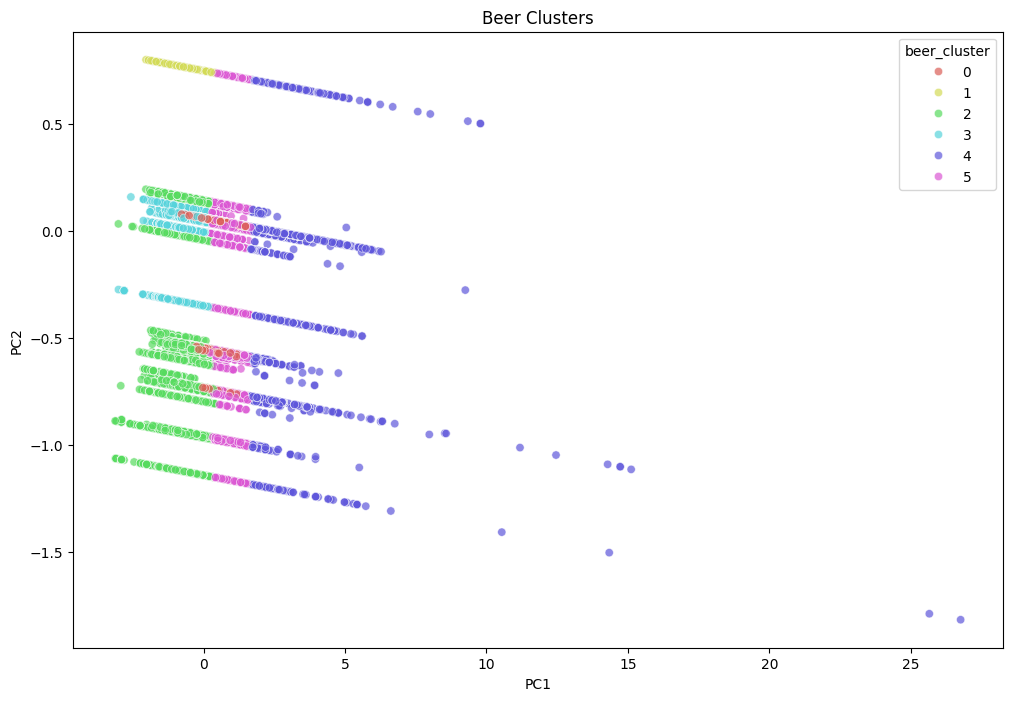

In [6]:
from sklearn.decomposition import PCA

print("\n--- Beer Cluster 2D Visualization (PCA) ---")

# 1. K-Means에 사용된 'beer_features_processed' 데이터를 2D로 축소
# (beer_features_processed는 Cell 29에서 이미 생성됨)
pca_beer = PCA(n_components=2)
beer_pca_result = pca_beer.fit_transform(beer_features_processed)

# 2. PCA 결과와 클러스터 라벨(beer_features_df['beer_cluster'])을 결합
# (beer_features_df와 beer_features_processed는 Cell 29에서
#  dropna()를 거쳤기 때문에 행의 순서와 개수가 일치합니다)
pca_beer_df = pd.DataFrame(
    data=beer_pca_result, 
    columns=['PC1', 'PC2']
)
pca_beer_df['beer_cluster'] = beer_features_df['beer_cluster'].values

# 3. 2D 산점도(Scatter Plot) 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="beer_cluster",
    palette=sns.color_palette("hls", K_BEERS), # K_BEERS = 6
    data=pca_beer_df,
    legend="full",
    alpha=0.7
)
plt.title('Beer Clusters')
plt.savefig('beer_cluster_pca.png')
print("Saved 'beer_cluster_pca.png'")
plt.show()

# Elbow 판단


--- Finding Optimal K for Beers (Elbow Method) ---
K=1 done...
K=2 done...
K=3 done...
K=4 done...
K=5 done...
K=6 done...
K=7 done...
K=8 done...
K=9 done...
K=10 done...
K=11 done...
K=12 done...
Saved 'beer_cluster_elbow.png'


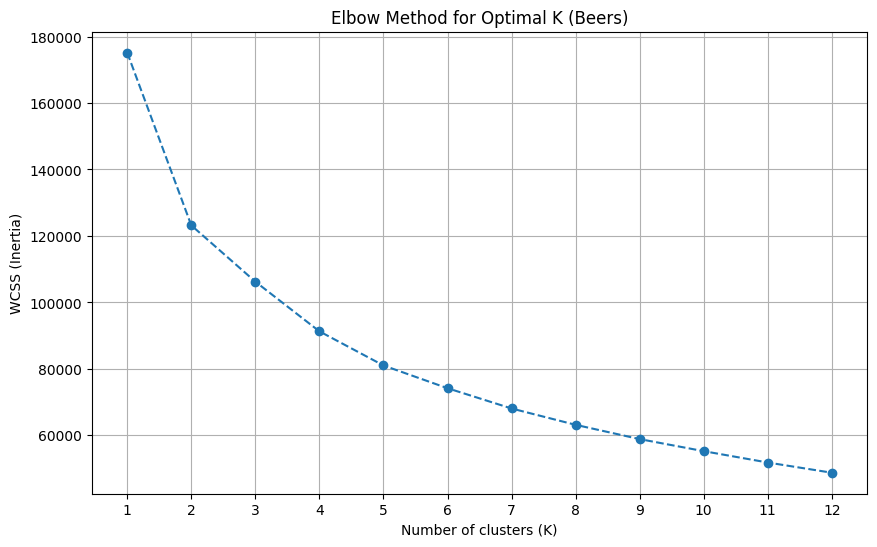

In [7]:
print("\n--- Finding Optimal K for Beers (Elbow Method) ---")
# (beer_features_processed는 Cell 29에서 이미 생성됨)

wcss_beer = []
k_range_beer = range(1, 13) # 최대 12개 조합이므로 12까지만 테스트

for k in k_range_beer:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(beer_features_processed)
    wcss_beer.append(kmeans_temp.inertia_)
    print(f"K={k} done...")

# Elbow Method 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range_beer, wcss_beer, marker='o', linestyle='--')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal K (Beers)')
plt.xticks(k_range_beer)
plt.grid(True)
plt.savefig('beer_cluster_elbow.png')
print("Saved 'beer_cluster_elbow.png'")
plt.show()

In [8]:
print("\n--- User Clustering (Pandas + Latent Features) ---")

user_style_affinity = pd.crosstab(df_sample['username'], df_sample['style_group'], normalize='index')
user_numeric_features = df_sample.groupby('username').agg(
    user_avg_score=('score', 'mean'),
    user_avg_abv=('abv', 'mean'),
    user_avg_smell=('smell', 'mean')
).fillna(0)


# 기존 user_profile_df에 SVD로 만든 user_latent_df를 결합합니다.
# user_latent_df는 SVD 셀에서 이미 생성되었다고 가정합니다.
if 'user_latent_df' in locals():
    user_profile_df = pd.concat([user_numeric_features, user_style_affinity, user_latent_df], axis=1).fillna(0)
    print("User profile에 Latent Features 결합 성공.")
else:
    print("Warning: user_latent_df가 없습니다. SVD 셀을 먼저 실행하세요.")
    user_profile_df = pd.concat([user_numeric_features, user_style_affinity], axis=1).fillna(0)
    
scaler_user = StandardScaler()
user_features_processed = scaler_user.fit_transform(user_profile_df)
    
kmeans_user = KMeans(n_clusters=K_USERS, random_state=42, n_init=10)
user_profile_df['user_cluster'] = kmeans_user.fit_predict(user_features_processed)

user_profile_df = user_profile_df.reset_index() 

print(f"User 클러스터링 완료. {len(user_profile_df)}명의 유저가 {K_USERS}개 그룹으로 분류됨.")
print("User Profile Head:")
print(user_profile_df.head())


--- User Clustering (Pandas + Latent Features) ---
User profile에 Latent Features 결합 성공.
User 클러스터링 완료. 24540명의 유저가 8개 그룹으로 분류됨.
User Profile Head:
  username  user_avg_score  user_avg_abv  user_avg_smell       Ale  \
0  --Dom--        4.176639      8.262377        4.296875  0.213115   
1     -DF-        3.952857      8.428571        4.142857  0.428571   
2     -MK-        3.906750      6.396250        4.291667  0.225000   
3  -NESTO-        4.001524      9.301159        0.000000  0.310976   
4    -Rick        4.362000      9.676923        4.388462  0.123077   

   Belgian/Saison       IPA  Lager/Wheat     Other  Sour/Wild  ...  \
0        0.073770  0.500000     0.008197  0.090164   0.000000  ...   
1        0.142857  0.000000     0.000000  0.142857   0.000000  ...   
2        0.050000  0.350000     0.125000  0.175000   0.000000  ...   
3        0.060976  0.158537     0.012195  0.158537   0.012195  ...   
4        0.015385  0.323077     0.015385  0.138462   0.000000  ...   

   user_la

# 시각화 클러스터링


--- User Cluster 2D Visualization (PCA) ---
Saved 'user_cluster_pca.png'


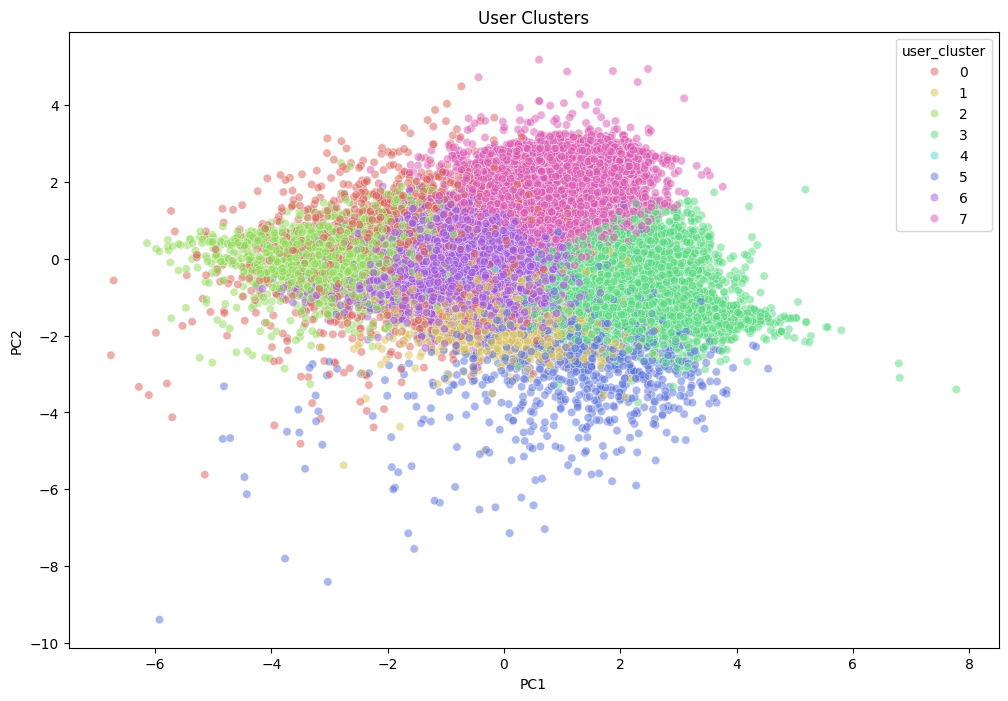

In [9]:
from sklearn.decomposition import PCA

print("\n--- User Cluster 2D Visualization (PCA) ---")

# 1. K-Means에 사용된 'user_features_processed' 데이터를 2D로 축소
# (user_features_processed는 Cell 30에서 이미 생성됨)
pca = PCA(n_components=2)
user_pca_result = pca.fit_transform(user_features_processed)

# 2. PCA 결과와 클러스터 라벨(user_profile_df['user_cluster'])을 결합
pca_df = pd.DataFrame(
    data=user_pca_result, 
    columns=['PC1', 'PC2']
)
# user_profile_df는 Cell 30에서 reset_index() 되었으므로 인덱스가 일치합니다.
pca_df['user_cluster'] = user_profile_df['user_cluster']

# 3. 2D 산점도(Scatter Plot) 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="user_cluster",
    palette=sns.color_palette("hls", K_USERS), # K_USERS = 8
    data=pca_df,
    legend="full",
    alpha=0.5
)
plt.title('User Clusters')
plt.savefig('user_cluster_pca.png')
print("Saved 'user_cluster_pca.png'")
plt.show()

# Elbow 판단


--- Finding Optimal K for Users (Elbow Method) ---
K=1 done...
K=2 done...
K=3 done...
K=4 done...
K=5 done...
K=6 done...
K=7 done...
K=8 done...
K=9 done...
K=10 done...
K=11 done...
K=12 done...
K=13 done...
K=14 done...
K=15 done...
Saved 'user_cluster_elbow.png'


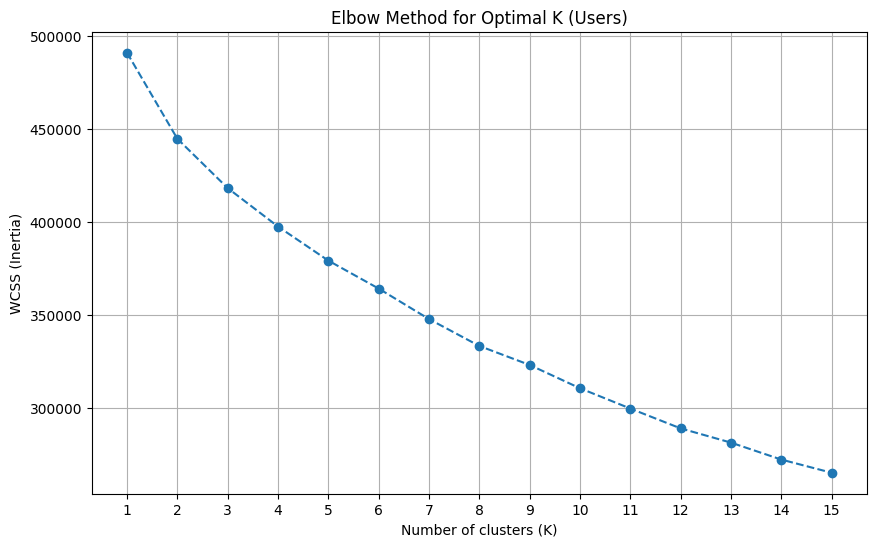

In [10]:
print("\n--- Finding Optimal K for Users (Elbow Method) ---")
# (user_features_processed는 Cell 30에서 이미 생성됨)

wcss = [] # 군집 내 오차 제곱합 (Within-Cluster Sum of Squares)
k_range = range(1, 16) # K=1부터 15까지 테스트

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(user_features_processed)
    wcss.append(kmeans_temp.inertia_) # inertia_가 WCSS 값입니다.
    print(f"K={k} done...")

# Elbow Method 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal K (Users)')
plt.xticks(k_range)
plt.grid(True)
plt.savefig('user_cluster_elbow.png')
print("Saved 'user_cluster_elbow.png'")
plt.show()

In [11]:
print("\n--- 최종 학습 데이터 생성 ---")

# SVD 셀에서 설정한 컴포넌트 개수와 동일하게 맞춰야 합니다.
N_COMPONENTS = 10 

# 1. df_sample + beer_cluster 병합
df_model = pd.merge(df_sample, beer_features_df[['beer_cluster']], on='beer_id', how='left')

# user_profile_df에서 가져올 컬럼 목록을 동적으로 생성합니다.
user_cols_to_merge = ['username', 'user_cluster', 'user_avg_score']

# SVD 셀이 정상적으로 실행되었다면 user_latent 컬럼들을 추가합니다.
if f'user_latent_{N_COMPONENTS-1}' in user_profile_df.columns:
    user_latent_cols = [f'user_latent_{i}' for i in range(N_COMPONENTS)]
    user_cols_to_merge.extend(user_latent_cols)
    print(f"User profile에서 {len(user_latent_cols)}개의 User Latent Features를 병합 목록에 추가합니다.")
else:
    print("Warning: user_profile_df에 user_latent 컬럼이 없습니다. SVD 셀 또는 Cell 6을 확인하세요.")

# 3. df_model + user_profile 정보 병합
df_model = pd.merge(df_model, 
                    user_profile_df[user_cols_to_merge], 
                    on='username', 
                    how='left')
    
# 4. df_model + beer_latent 정보 병합
if 'beer_latent_df' in locals() and f'beer_latent_{N_COMPONENTS-1}' in beer_latent_df.columns:
    df_model = pd.merge(df_model, beer_latent_df, on='beer_id', how='left')
    print("최종 데이터에 Beer Latent Features 병합 성공.")
else:
    print("Warning: beer_latent_df가 없습니다. SVD 셀을 먼저 실행하세요.")

# 5. Target 변수 생성 (THRESHOLD는 0.5 또는 0.9 등으로 상향 조정 권장)
THRESHOLD = 0.5
df_model['is_top_pick'] = (df_model['score'] > (df_model['user_avg_score'] + THRESHOLD)).astype(int)

print("'is_top_pick' 타겟 변수 생성 완료.")
print(df_model['is_top_pick'].value_counts(normalize=True))

# 6. (메모리 해제)
del df_sample
del beer_features_df
if 'user_profile_df' in locals(): del user_profile_df
if 'beer_latent_df' in locals(): del beer_latent_df
print("중간 데이터프레임 메모리 해제 완료.")


--- 최종 학습 데이터 생성 ---
User profile에서 10개의 User Latent Features를 병합 목록에 추가합니다.
최종 데이터에 Beer Latent Features 병합 성공.
'is_top_pick' 타겟 변수 생성 완료.
is_top_pick
0    0.866971
1    0.133029
Name: proportion, dtype: float64
중간 데이터프레임 메모리 해제 완료.


In [12]:
# --- 3-4. Train/Test/Validation Split ---
print("\n--- 3-4. Train/Test/Validation Split ---")

N_COMPONENTS = 10 

# 1.'style_group'과 'geo_group'을 직접 피처로 추가 클러스터링한 내용은 간략화 되어 있으므로 추가적으로 같이 넣어봤음 
features_to_use = [
    'smell', 'taste', 'feel', 'abv',
    'style_group',    
    'geo_group',      
    'beer_cluster',   # (K-Means가 만든 '요약본/힌트')
    'user_cluster'    # (K-Means가 만든 '요약본/힌트')
]

cb_cluster_features_count = len(features_to_use)

# 2. Latent Features (CF)
user_latent_cols = [f'user_latent_{i}' for i in range(N_COMPONENTS)]
beer_latent_cols = [f'beer_latent_{i}' for i in range(N_COMPONENTS)]
features_to_use.extend(user_latent_cols)
features_to_use.extend(beer_latent_cols)

latent_features_count = len(user_latent_cols) + len(beer_latent_cols)
print(f"Latent Features ({latent_features_count}) added to model features.")
print(f"CB + Cluster Features ({cb_cluster_features_count}) added to model features.")
print(f"--- Total modeling features: {len(features_to_use)} ---")

target = 'is_top_pick'
    
# 3. (오류 방지) df_model에 해당 컬럼들이 *모두* 존재하는지 확인
all_cols_needed = features_to_use + [target]
missing_cols = [col for col in all_cols_needed if col not in df_model.columns]

if missing_cols:
    print(f"!!! Error: The following columns are missing in df_model: {missing_cols}")
else:
    # 4. 결측치(NaN) 처리
    # print(f"Original rows before imputation: {len(df_model)}") # (주석 처리됨)
    df_model[features_to_use] = df_model[features_to_use].fillna(0)
    df_model = df_model.dropna(subset=[target]) # y(정답)가 NaN인 것만 제거
    
    print(f"Final rows after imputation (NaN handled): {len(df_model)}")
        
    X = df_model[features_to_use]
    y = df_model[target]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    print(f"Train: {X_train_sub.shape}, Validation: {X_val.shape}, Test: {X_test.shape}") # (기존 영어 유지)

    # 5
    print("\n--- Performing LabelEncoding (Handling Unseen Labels) ---")
    categorical_features_final = ['style_group', 'geo_group', 'beer_cluster', 'user_cluster']
    encoders = {} 
    
    for col in categorical_features_final:
        le = LabelEncoder()
        
        all_categories = pd.concat([
            X_train_sub[col].astype(str), 
            X_val[col].astype(str), 
            X_test[col].astype(str)
        ]).unique()
        
        le.fit(all_categories)
        
        X_train_sub[col] = le.transform(X_train_sub[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        encoders[col] = le

    print("Categorical feature encoding complete (converted to int).")


--- 3-4. Train/Test/Validation Split ---
Latent Features (20) added to model features.
CB + Cluster Features (8) added to model features.
--- Total modeling features: 28 ---
Final rows after imputation (NaN handled): 1863769
Train: (1192812, 28), Validation: (298203, 28), Test: (372754, 28)

--- Performing LabelEncoding (Handling Unseen Labels) ---
Categorical feature encoding complete (converted to int).


In [14]:
# --- 3-6. XGBoost 학습 (Pandas) ---
print("\n--- XGBoost Hybrid 모델 학습 시작 ---")
hybrid_model_xgb = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc',
    n_estimators=1000, learning_rate=0.1, max_depth=6,
    n_jobs=-1, random_state=42,
    enable_categorical=True, 
    early_stopping_rounds=50,
    scale_pos_weight=3.5
)
    
hybrid_model_xgb.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],      
    #early_stopping_rounds=50,      
    verbose=100,
)

print("모델 학습 완료.")


--- XGBoost Hybrid 모델 학습 시작 ---
[0]	validation_0-auc:0.818664
[100]	validation_0-auc:0.898416
[200]	validation_0-auc:0.908983
[300]	validation_0-auc:0.914659
[400]	validation_0-auc:0.918466
[500]	validation_0-auc:0.92105
[600]	validation_0-auc:0.923284
[700]	validation_0-auc:0.925157
[800]	validation_0-auc:0.926692
[900]	validation_0-auc:0.928062
[999]	validation_0-auc:0.929262
모델 학습 완료.


In [16]:
# --- 3-7. 평가 ---
print("\n--- 모델 평가 (Test Set) ---")
preds_proba = hybrid_model_xgb.predict_proba(X_test)[:, 1]
preds_binary = hybrid_model_xgb.predict(X_test)
auc_score = roc_auc_score(y_test, preds_proba)

print(f"\n[Hybrid Model - Test Set 결과]")
print(f"AUC (Area Under Curve): {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, preds_binary))


--- 모델 평가 (Test Set) ---

[Hybrid Model - Test Set 결과]
AUC (Area Under Curve): 0.9300

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93    322855
           1       0.56      0.74      0.64     49899

    accuracy                           0.89    372754
   macro avg       0.76      0.83      0.79    372754
weighted avg       0.90      0.89      0.89    372754



In [17]:
# --- P@K, R@K 계산을 위한 사전 준비 ---

# 1. X_test (15740행)의 인덱스를 가져옵니다.
test_indices = X_test.index

# 2. X_test의 인덱스를 사용해 원본 df_model에서 'username'을 가져옵니다.
# (df_model이 del 되었다면, Cell 8의 X, y 분할 전에 df_model[['username']]을 따로 복사해 두어야 합니다.)
# 여기서는 df_model이 아직 메모리에 있다고 가정합니다.
# (만약 Cell 7에서 df_model을 del 했다면 Cell 7을 다시 실행해 df_model을 만들어야 합니다)

# (Cell 8을 다시 실행해야 할 수도 있습니다)
# df_model = df_model.dropna(subset=all_cols_needed)
# X = df_model[features_to_use]
# y = df_model[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_sub, X_val, y_train_sub, y_val = ...

# (Cell 10 이후)
# X_test (피처)
# y_test (실제 값: 0 또는 1)
# hybrid_model_xgb (학습된 모델)

# 3. Test Set에 대한 'username', '실제값', '예측 확률'을 하나의 DataFrame으로 결합
test_results_df = df_model.loc[y_test.index, ['username']].copy()
test_results_df['is_top_pick_true'] = y_test
test_results_df['probability_top_pick'] = hybrid_model_xgb.predict_proba(X_test)[:, 1]

print("P@K 계산 준비 완료:")
print(test_results_df.head())

P@K 계산 준비 완료:
              username  is_top_pick_true  probability_top_pick
1353722      chewy6935                 0              0.014774
1186834      jbarletto                 1              0.570331
1855555  HopsintheSack                 1              0.884804
541603    beergorrilla                 0              0.021700
1116382       AzIpaGuy                 0              0.010498


# 시각화


--- Predicted Probability Distribution (Test Set) ---
Saved 'prediction_distribution.png'


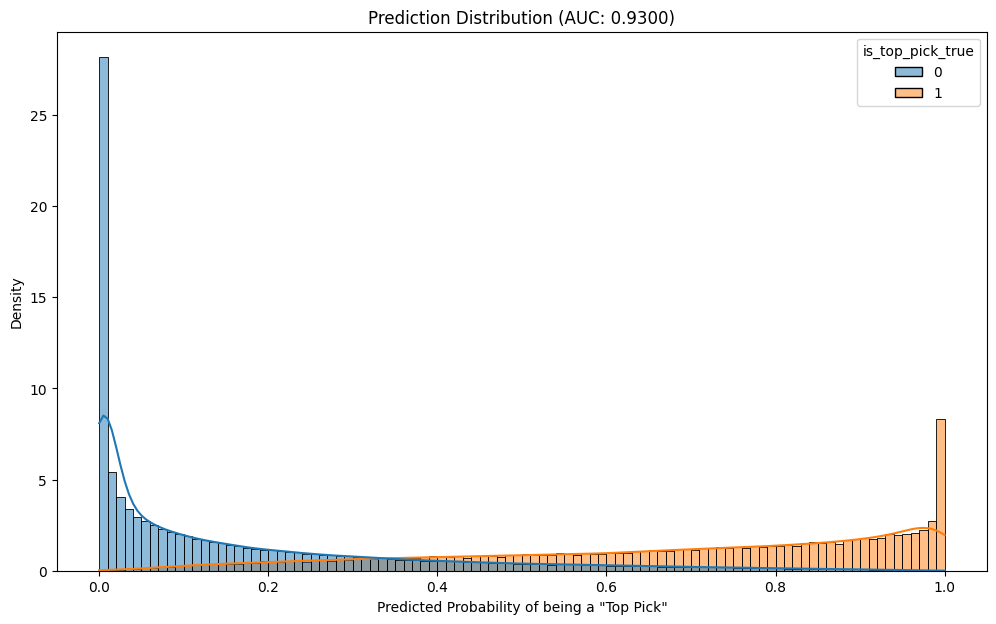

In [18]:
print("\n--- Predicted Probability Distribution (Test Set) ---")

plt.figure(figsize=(12, 7))
sns.histplot(
    data=test_results_df, 
    x='probability_top_pick', 
    hue='is_top_pick_true', # 0(False)과 1(True)을 다른 색으로
    kde=True,
    stat="density", 
    common_norm=False,
    bins=100
)
plt.title(f'Prediction Distribution (AUC: {auc_score:.4f})')
plt.xlabel('Predicted Probability of being a "Top Pick"')
plt.savefig('prediction_distribution.png')
print("Saved 'prediction_distribution.png'")
plt.show()

In [19]:
def calculate_ranking_metrics(df_results, k=10):
    """
    K=10일 때의 Precision@K, Recall@K, MAP@K를 계산합니다.
    
    Args:
    df_results (pd.DataFrame): 'username', 'is_top_pick_true', 'probability_top_pick' 컬럼 필요.
    k (int): 상위 몇 개를 추천 리스트로 볼 것인지 결정.
    """
    
    user_groups = df_results.groupby('username')
    
    user_metrics = {
        'precision@k': [],
        'recall@k': [],
        'map@k': []
    }
    
    for username, group in user_groups:
        # 1. 실제 Top Pick이 하나도 없는 유저는 평가에서 제외 (Recall 계산 불가)
        total_true_positives = group['is_top_pick_true'].sum()
        if total_true_positives == 0:
            continue
            
        # 2. 예측 확률 순으로 정렬 (추천 리스트 생성)
        top_k_list = group.sort_values('probability_top_pick', ascending=False).head(k)
        
        # 3. K개 리스트 중 실제 Top Pick 개수 (Hits)
        hits_df = top_k_list[top_k_list['is_top_pick_true'] == 1]
        num_hits = len(hits_df)
        
        # 4. P@K, R@K 계산
        precision_at_k = num_hits / k
        recall_at_k = num_hits / total_true_positives
        
        user_metrics['precision@k'].append(precision_at_k)
        user_metrics['recall@k'].append(recall_at_k)
        
        # 5. MAP@K (Mean Average Precision) 계산
        if num_hits > 0:
            # 리스트 중 'Hit'의 순위를 가져옴 (1부터 시작)
            hit_ranks = (top_k_list.reset_index(drop=True).index + 1)[top_k_list['is_top_pick_true'] == 1]
            
            # (1/1위) + (2/3위) + (3/7위) ...
            ap_sum = (pd.Series(range(1, num_hits + 1)) / hit_ranks).sum()
            average_precision = ap_sum / num_hits 
            user_metrics['map@k'].append(average_precision)
        else:
            user_metrics['map@k'].append(0.0)

    # 모든 유저의 평균을 반환
    if not user_metrics['precision@k']:
        print("Warning: 평가 가능한 유저가 없습니다 (Test Set에 실제 Top Pick이 없음).")
        return pd.Series(index=['precision@k', 'recall@k', 'map@k'], data=[0.0, 0.0, 0.0])
        
    return pd.Series(user_metrics).apply(np.mean)

# K=5, K=10일 때의 랭킹 지표 계산
print("\n--- 랭킹 평가 지표 (Test Set) ---")
k_5_metrics = calculate_ranking_metrics(test_results_df, k=5)
print(f"\n[Metrics @ K=5]\n{k_5_metrics}")

k_10_metrics = calculate_ranking_metrics(test_results_df, k=10)
print(f"\n[Metrics @ K=10]\n{k_10_metrics}")


--- 랭킹 평가 지표 (Test Set) ---

[Metrics @ K=5]
precision@k    0.453369
recall@k       0.801433
map@k          0.863522
dtype: float64

[Metrics @ K=10]
precision@k    0.301752
recall@k       0.908668
map@k          0.841338
dtype: float64


# 시각화 


--- Ranking Metrics vs. K ---
Saved 'ranking_metrics_vs_k.png'


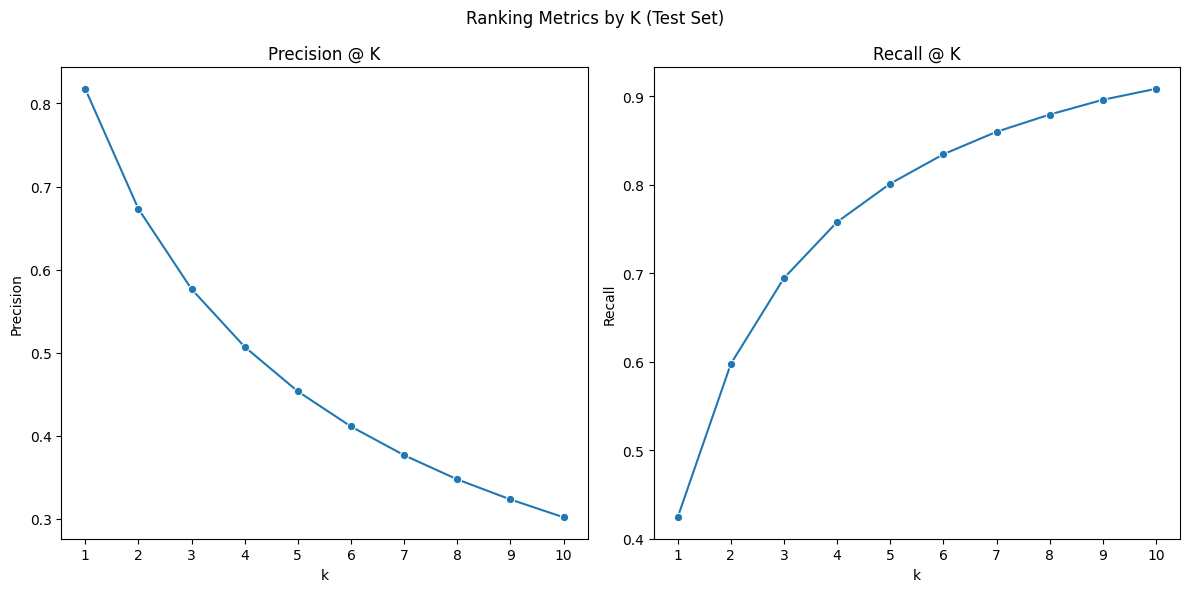

In [20]:
print("\n--- Ranking Metrics vs. K ---")

ranking_results = []
# (calculate_ranking_metrics 함수는 Cell 37에 이미 정의됨)

for k in range(1, 11):
    metrics = calculate_ranking_metrics(test_results_df, k=k)
    metrics['k'] = k
    ranking_results.append(metrics)

ranking_df = pd.DataFrame(ranking_results)

# P@K, R@K 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=ranking_df, x='k', y='precision@k', marker='o')
plt.title('Precision @ K')
plt.ylabel('Precision')
plt.xticks(range(1, 11))

plt.subplot(1, 2, 2)
sns.lineplot(data=ranking_df, x='k', y='recall@k', marker='o')
plt.title('Recall @ K')
plt.ylabel('Recall')
plt.xticks(range(1, 11))

plt.suptitle('Ranking Metrics by K (Test Set)')
plt.tight_layout()
plt.savefig('ranking_metrics_vs_k.png')
print("Saved 'ranking_metrics_vs_k.png'")
plt.show()


Saved 'feature_importance.png'


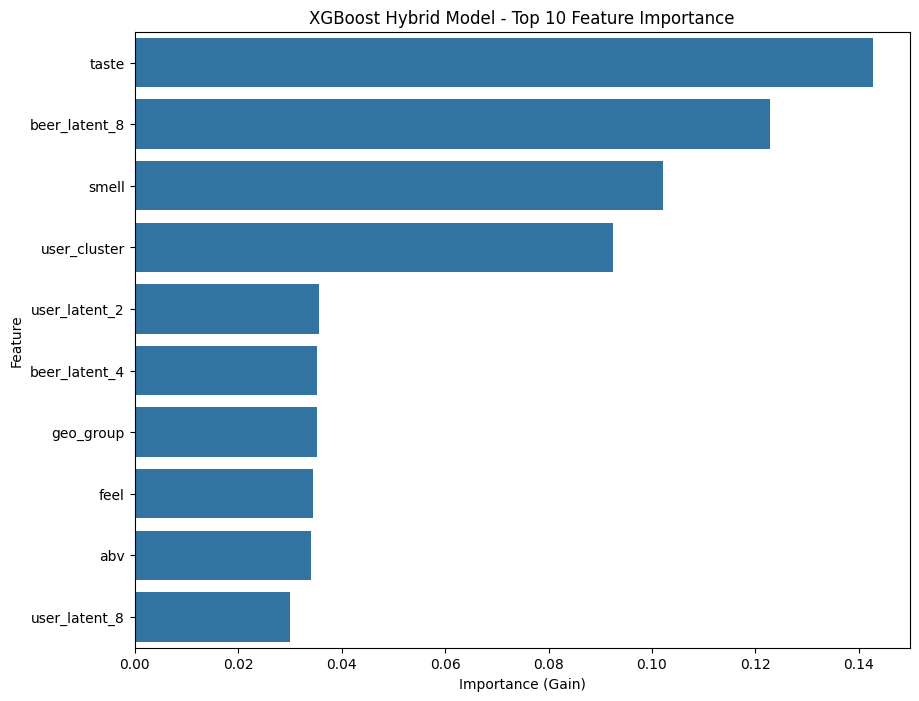

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# (X_train_sub, hybrid_model_xgb가 학습된 상태라고 가정)

# 1. 피처 중요도 추출
feature_importance = hybrid_model_xgb.feature_importances_
feature_names = X_train_sub.columns

# 2. DataFrame으로 정렬
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# 3. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10)) # 상위 10개
plt.title('XGBoost Hybrid Model - Top 10 Feature Importance')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
print("\nSaved 'feature_importance.png'")